<a href="https://www.kaggle.com/code/syerramilli/ps3e24-pytorch-fnn?scriptVersionId=148387050" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Introduction

The objective of this classification task is to predict the smoking status (smoking or not) of an individual using bio-signal data. Within this notebook, we perform some exploratory data analysis, and then train and tune a feed-forward neural network implemented in PyTorch (and PyTorch lightning).


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score

# pytorch modules
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pytorch_lightning as pl
import torchmetrics

import optuna

from pathlib import Path
from typing import Optional, Dict, Tuple

plt.style.use('ggplot')
plt.rcParams.update(**{'figure.dpi':150})

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
path = Path('/kaggle/input/playground-series-s3e24')

train = pd.read_csv(path / 'train.csv', index_col = ['id'])
test = pd.read_csv(path / 'test.csv', index_col = ['id'])

## Inspecting the data

In [3]:
train.head()

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
id,,,,,,,,,,,,,,,,,,,,,
0,55,165,60,81.0,0.5,0.6,1,1,135,87,...,40,75,16.5,1,1.0,22,25,27,0,1
1,70,165,65,89.0,0.6,0.7,2,2,146,83,...,57,126,16.2,1,1.1,27,23,37,1,0
2,20,170,75,81.0,0.4,0.5,1,1,118,75,...,45,93,17.4,1,0.8,27,31,53,0,1
3,35,180,95,105.0,1.5,1.2,1,1,131,88,...,38,102,15.9,1,1.0,20,27,30,1,0
4,30,165,60,80.5,1.5,1.0,1,1,121,76,...,44,93,15.4,1,0.8,19,13,17,0,1


In [4]:
print(f'Number of observations in training data: {train.shape[0]}' )
print(f'Number of columns in training data: {train.shape[1]}')

Number of observations in training data: 159256
Number of columns in training data: 23


All the columns are numerical, and there are no missing values.

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 159256 entries, 0 to 159255
Data columns (total 23 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   age                  159256 non-null  int64  
 1   height(cm)           159256 non-null  int64  
 2   weight(kg)           159256 non-null  int64  
 3   waist(cm)            159256 non-null  float64
 4   eyesight(left)       159256 non-null  float64
 5   eyesight(right)      159256 non-null  float64
 6   hearing(left)        159256 non-null  int64  
 7   hearing(right)       159256 non-null  int64  
 8   systolic             159256 non-null  int64  
 9   relaxation           159256 non-null  int64  
 10  fasting blood sugar  159256 non-null  int64  
 11  Cholesterol          159256 non-null  int64  
 12  triglyceride         159256 non-null  int64  
 13  HDL                  159256 non-null  int64  
 14  LDL                  159256 non-null  int64  
 15  hemoglobin           1

## Target


The goal of this binary classification task is to predict `smoking` - whether the individual is smoking (label 1) or not (label 0). There is not much class imbalance in the training data.  

In [6]:
# target
train['smoking'].value_counts() / train.shape[0] * 100

smoking
0    56.2635
1    43.7365
Name: count, dtype: float64

## EDA on features

We first check if there is any feature for which its mode has more than 90% of the observations. It is unlikely that any model can reliably use such features. So, we will drop them

In [7]:
from numbers import Number
def get_mode_fraction(x:pd.Series) -> float:
    cts = x.value_counts(sort=True, ascending=False)
    return cts.iloc[0]/x.shape[0]

def filter_greater_than(series:pd.Series,threshold:Number) -> pd.Series:
    '''
    Returns series elements greater than threshold. This funtion can be
    used with the .pipe methods
    '''
    return series[series>threshold]

high_mode_per = (
    train.drop('smoking', axis=1)
    .apply(get_mode_fraction)
    .pipe(filter_greater_than, threshold = 0.9)
)
high_mode_per

hearing(left)     0.976026
hearing(right)    0.976579
Urine protein     0.947292
dtype: float64

In [8]:
# drop these columns
train = train.drop(high_mode_per.index.tolist(), axis=1)

### Checks on features

We check on the cholesterol related features
1. HDL: high-density lipoprotein level (good)
2. LDL: low-density lipoprotein level (bad)
3. triglyceride: type of fat (good/bad)
4. Cholesterol: total amount of cholestorol


The total amount of cholestorol is given by Cholesterol = HDL + LDL + 0.2 * triglyceride (Source: https://my.clevelandclinic.org/health/articles/11920-cholesterol-numbers-what-do-they-mean). There are some entries where this relation is violated by a lot. 

In [9]:
error = (train['HDL'] + train['LDL'] + 0.2*train['triglyceride'] - train['Cholesterol'])
error.describe()

count    159256.000000
mean          0.187410
std          11.403006
min        -149.200000
25%          -0.600000
50%          -0.200000
75%           0.400000
max        1692.800000
dtype: float64

There a are a few LDL entries which are larger than the corresponding total Cholesterol entries.

In [10]:
for column in ['HDL', 'LDL', 'triglyceride']:
    factor = 0.2 if column == 'triglyceride' else 1
    print((
        f'Number of cases where {("0.2 * " if column =="triglyceride" else "") + column}'
        ' > Cholesterol: ' 
        f'{(factor * train[column] > train["Cholesterol"]).sum()}'
    ))

Number of cases where HDL > Cholesterol: 0
Number of cases where LDL > Cholesterol: 20
Number of cases where 0.2 * triglyceride > Cholesterol: 0


These 20 entries tend to have abnormally high LDL values. There are also quite a few entries with abnormally low values of LDL. 

In [11]:
fig = px.scatter(
    train, x='Cholesterol', y='LDL', 
    marginal_x='box', marginal_y='box',
    log_y=True, log_x=True,
    width = 500, height=500
)
fig.show()

We will therefore discard the LDL column, since we are not sure how reliable the measurements are. Also, the LDL values can be gleaned from the others. 

In [12]:
# drop LDL
del train['LDL']

### Feature engineering

Before we delve further, we will add additional features based on intuition.

1. bmi = Weight(kg) / (Height(cm) * 0.01)^2
2. hdl_total_ratio = HDL / Cholesterol

In [13]:
def new_features(df:pd.DataFrame):
    '''
    Adds new features in place
    '''
    
    df['bmi'] = df['weight(kg)'] / (0.01 * df['height(cm)']) ** 2
    df['hdl_total_ratio'] = df['HDL'] / df['Cholesterol']
    
new_features(train)

### Number of unique values.

Next, we compute the number of unique values for each column. It appears that `dental carries` is binary valued.

In [14]:
n_unique_vals = train.drop('smoking', axis=1).nunique().sort_values()
n_unique_vals

dental caries             2
height(cm)               14
eyesight(right)          17
age                      18
eyesight(left)           20
weight(kg)               28
serum creatinine         28
relaxation               75
HDL                     108
systolic                112
hemoglobin              134
AST                     140
bmi                     169
ALT                     188
Cholesterol             227
fasting blood sugar     229
Gtp                     362
triglyceride            392
waist(cm)               531
hdl_total_ratio        7762
dtype: int64

### Skewness

We now compute the skewness for the 19 non-binary features and sort them by their skewness values. There are 7 columns that have a large positive skew (skewness > 1), and one with borderline positive skew (triglyceride).

In [15]:
numerical_cols = train.drop(['smoking', 'dental caries'], axis=1).columns.tolist()
skewness = train[numerical_cols].skew().sort_values()
skewness

hemoglobin             -0.633571
height(cm)             -0.269915
Cholesterol             0.043488
waist(cm)               0.072446
relaxation              0.176350
systolic                0.219925
age                     0.291697
weight(kg)              0.378075
bmi                     0.440607
HDL                     0.758884
hdl_total_ratio         0.768509
triglyceride            0.986228
serum creatinine        1.511059
fasting blood sugar     3.461099
Gtp                     5.414827
eyesight(right)         8.486849
eyesight(left)          8.890572
AST                    11.592346
ALT                    34.830012
dtype: float64

We first plot the histograms of the features with non-skew. There seem to be some outliers in some of the features, especially triglyceride

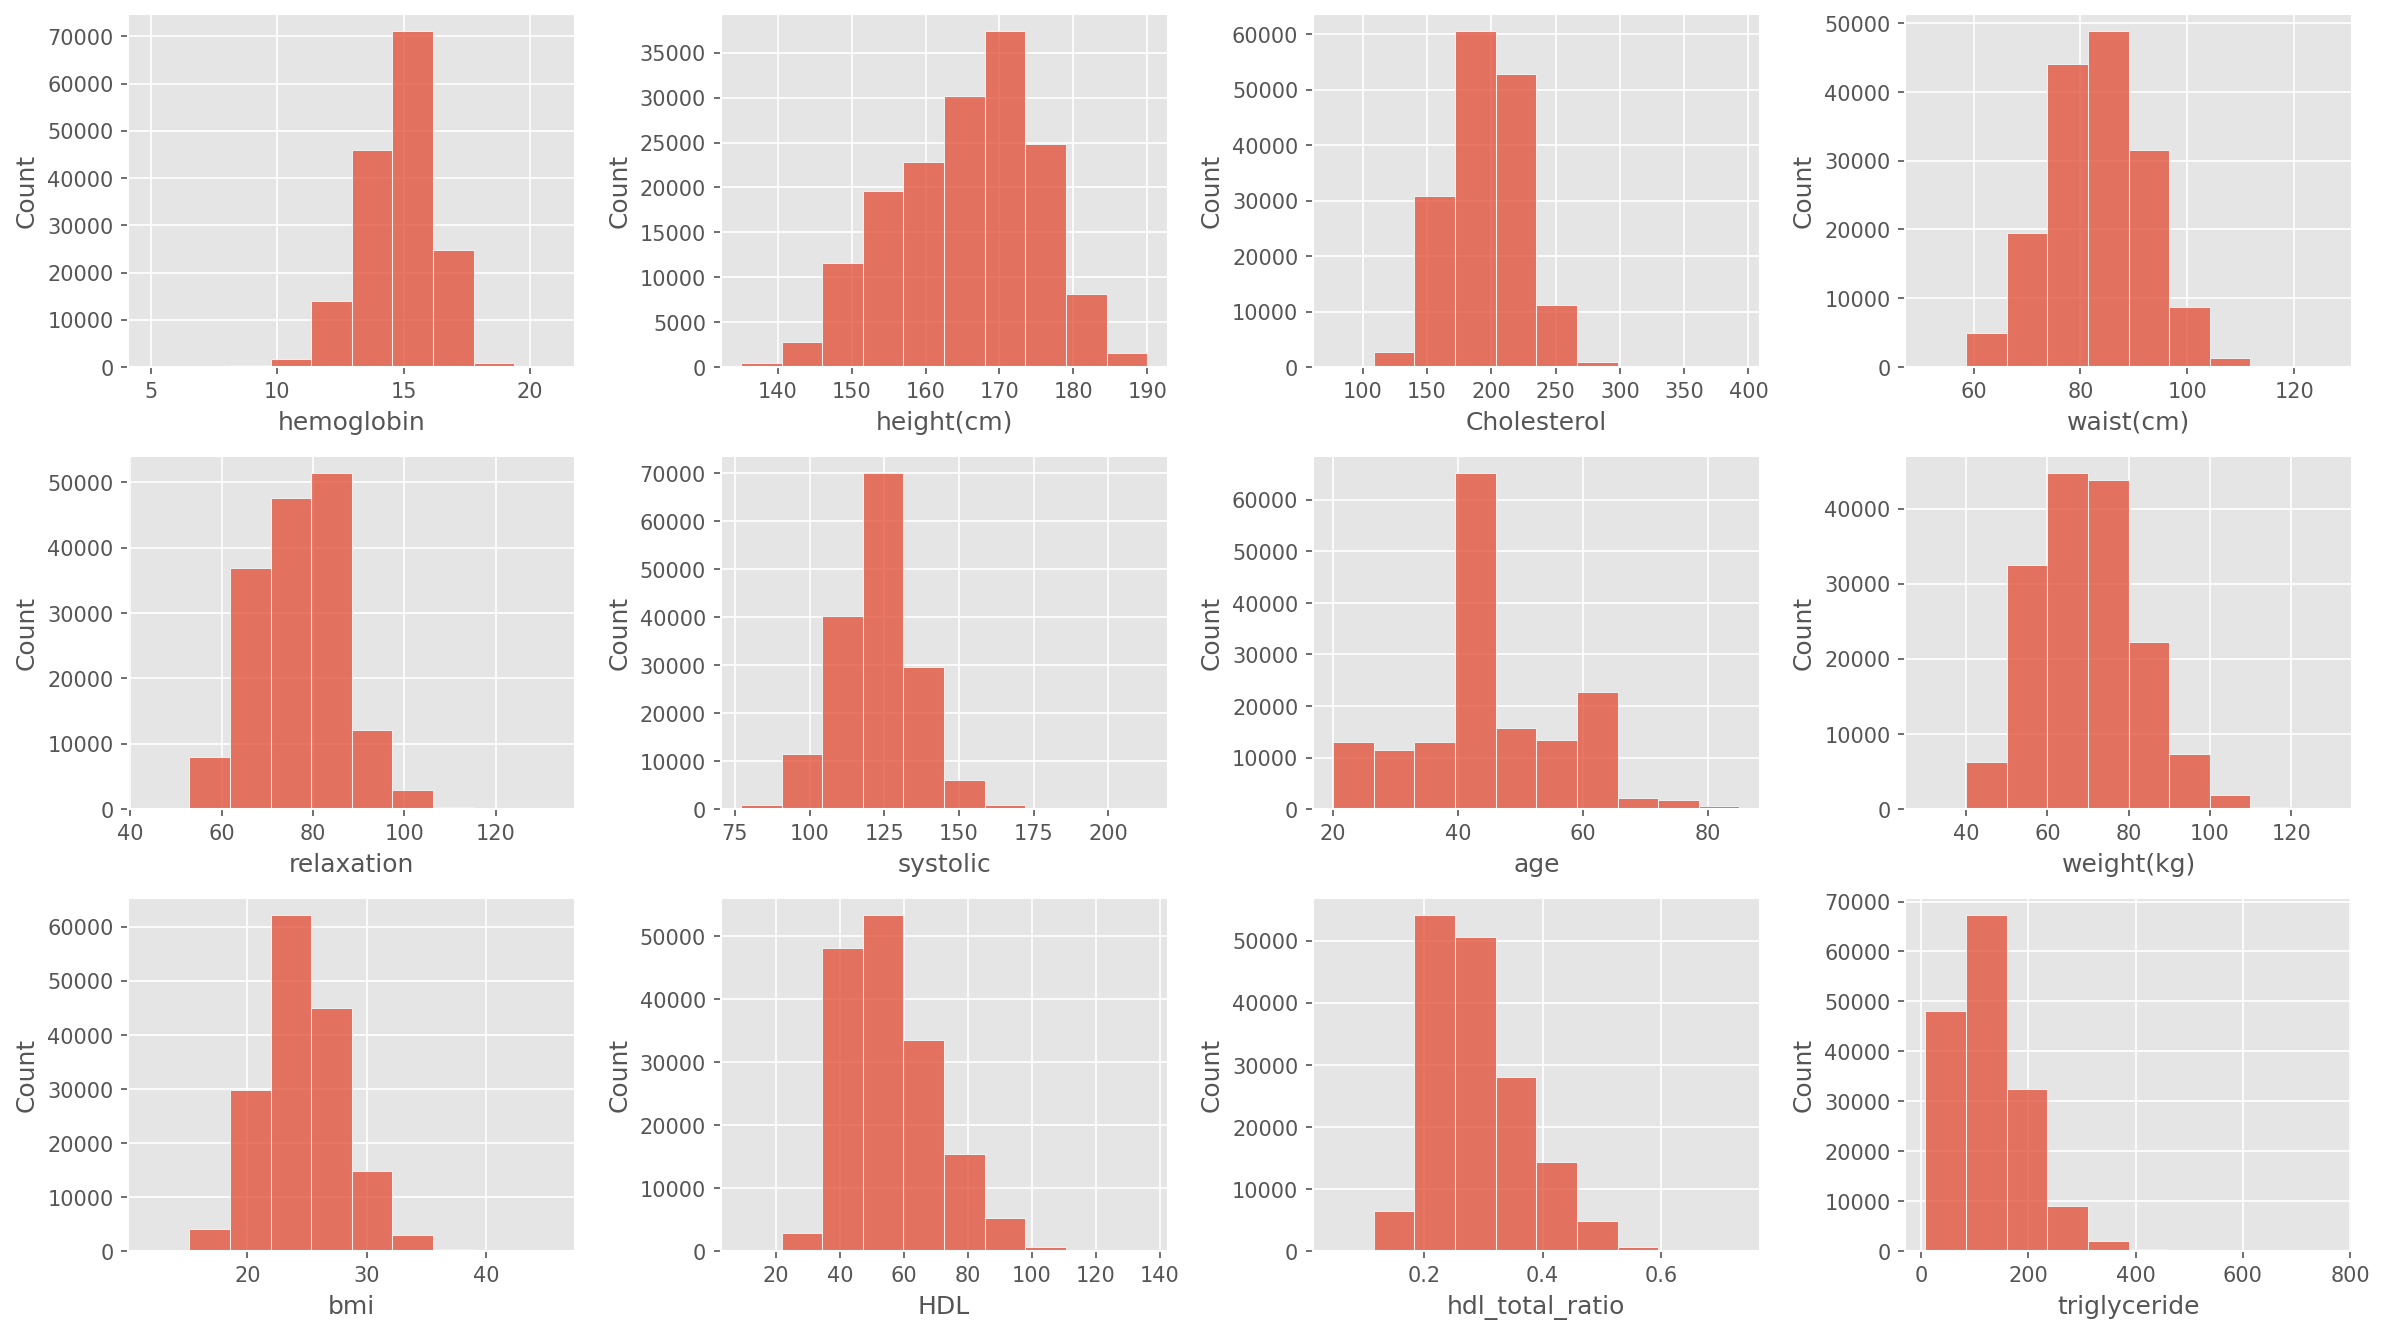

In [16]:
columns_w_no_positive_skew = skewness[skewness <= 1].index
n_rows = 3
n_cols = 4

fig, axs = plt.subplots(n_rows, n_cols, figsize = (4 * n_cols, 3 * n_rows))
for i in range(n_rows):
    for j in range(n_cols):
        _ = sns.histplot(data=train, x=columns_w_no_positive_skew[n_cols * i + j], ax=axs[i,j], bins=10)
        
fig.tight_layout()

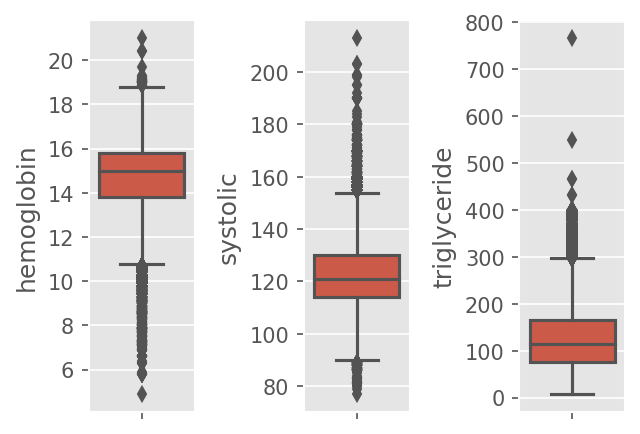

In [17]:
columns_further = ['hemoglobin', 'systolic', 'triglyceride']

n_cols = 3
fig, axs = plt.subplots(1, n_cols, figsize=(1.5 * n_cols, 3))
for i in range(n_cols):
    _ = sns.boxplot(train, y = columns_further[i], ax=axs[i])

fig.tight_layout()

In [18]:
cols_w_positive_skew = skewness[skewness > 1].index
train[cols_w_positive_skew] = train[cols_w_positive_skew].apply(np.log1p)
train = train.rename({col:f'log1p_{col}' for col in cols_w_positive_skew}, axis=1)

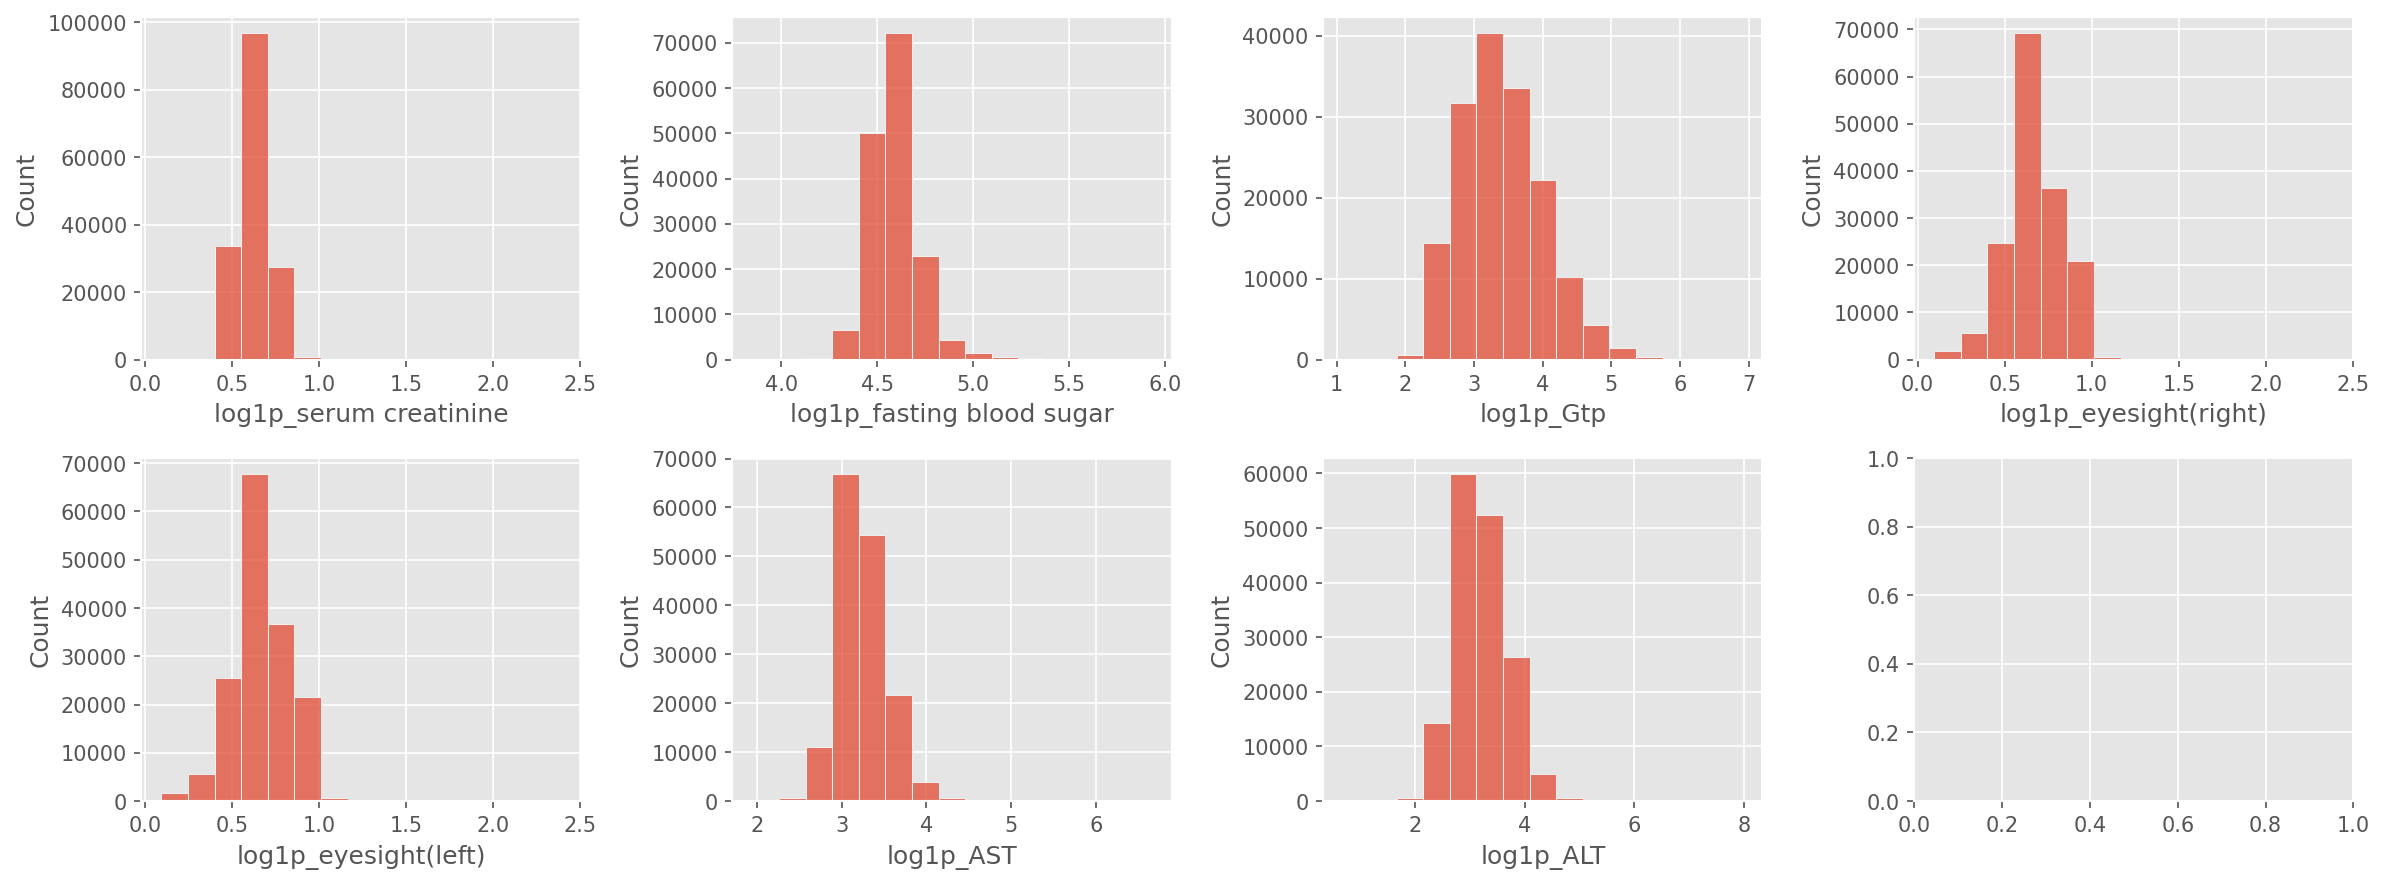

In [19]:
n_rows = 2
n_cols = 4

fig, axs = plt.subplots(n_rows, n_cols, figsize = (4 * n_cols, 3 * n_rows))
for i in range(n_rows):
    for j in range(n_cols):
        col_index = n_cols * i + j
        if col_index == len(cols_w_positive_skew):
            break
        column = cols_w_positive_skew[col_index]
        _ = sns.histplot(train, x=f'log1p_{column}', ax=axs[i,j], bins=15)
        
fig.tight_layout()

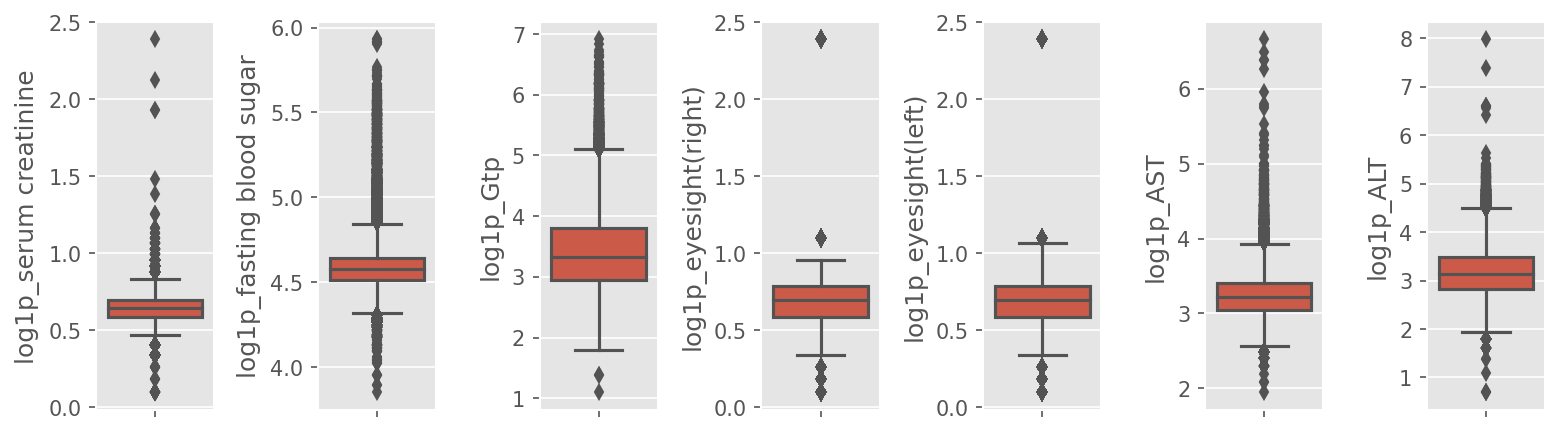

In [20]:
n_cols = len(cols_w_positive_skew)
fig, axs = plt.subplots(1, n_cols, figsize=(1.5 * n_cols, 3))
for i in range(n_cols):
    _ = sns.boxplot(train, y = f'log1p_{cols_w_positive_skew[i]}', ax=axs[i])
fig.tight_layout()

### Correlation analysis - hierarchical clustering

We now compute the correlations between pairs of the features, and drop ones which are highly correlated with each other. Since there are many columns, we will perform hierarchical clustering to cluster the features.

Hierarchical clustering arranges the data (in our case, features) using a dissimilarity (or distance) matrix. In our case, we compute the dissimilarity between two features $x_i$ and $x_j$  as
$$
    \large
    d(x_i,x_j) = 1 - |\rho(x_i, x_j)|,
$$
where $\rho(x_i, x_j)$ is the Pearson correlation between $x_1$ and $x_2$.

In [21]:
# hierarchical clustering
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

# construct correlation matrix
corr_matrix = train.drop(['smoking', 'dental caries'], axis=1).corr(method='pearson')

# hierarchical cluster based on the correlations
dissimilarity = 1 - abs(corr_matrix.values)

After computing the dissimilaity matrix, we then perform hierarchical clustering on the features. We can then visualize the hierarchy of relationships using a dendrogram plot, which displays a tree-like structure, with branches that represent the merging of similar features at different levels of dissimilarity. The leaves of the dendograms are the features.

There are some features that have an absololute value of correlation > 0.8: 
1. `weight(kg)`, `waist(cm)`, `bmi`
2. `HDL`, `hdl_total_ratio`

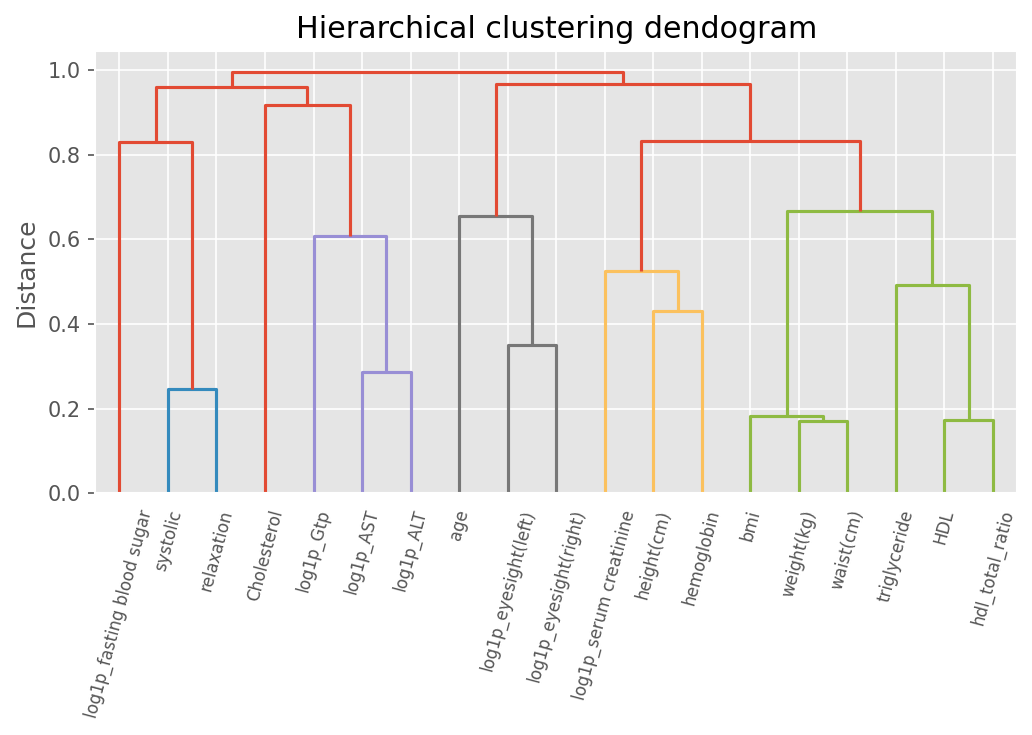

In [22]:
linkage_matrix = hierarchy.linkage(squareform(dissimilarity), method='complete')

# plot the dendogram
fig,ax = plt.subplots(1,1,figsize=(7,5))
dendogram = hierarchy.dendrogram(
    linkage_matrix, ax=ax, 
    labels=corr_matrix.columns.tolist(),
)
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=75, fontsize=8)
_ = ax.set_ylabel('Distance')
_ = ax.set_title('Hierarchical clustering dendogram')
fig.tight_layout()

## Distributions by class

We now look at the marginal distributions of the features conditioned by class.

We begin by plotting the counts of the two levels for `dental caries` with the counts grouped by the response `smoking`. Clearly the percentage of smokers is slightly large when `dental caries` = 1

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



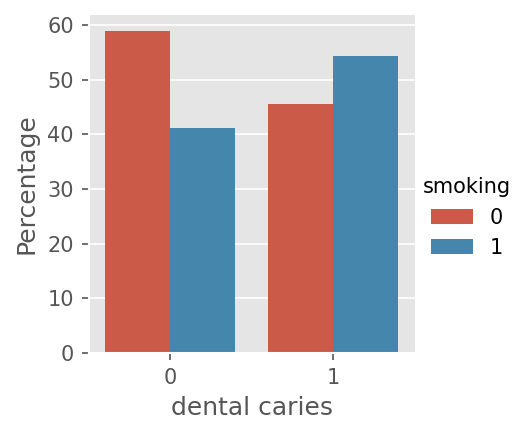

In [23]:
_ = (
    train
    .groupby('dental caries')['smoking']
    .value_counts(normalize=True)
    .mul(100)
    .rename('Percentage')
    .reset_index()
    .pipe((sns.catplot, 'data'), x='dental caries', y='Percentage', hue='smoking', kind='bar', height=3)
)

We now plot the boxplots of the remaning features grouped by the different classes. There are quite a few features that have different distributions conditioned on the class - notably `height(cm)`, `weight(kg)`, `hemoglobin` and `log1p_Gtp` - but it is somewhat difficult to conclude definitively since there are many outliers within each conditional distribution. 

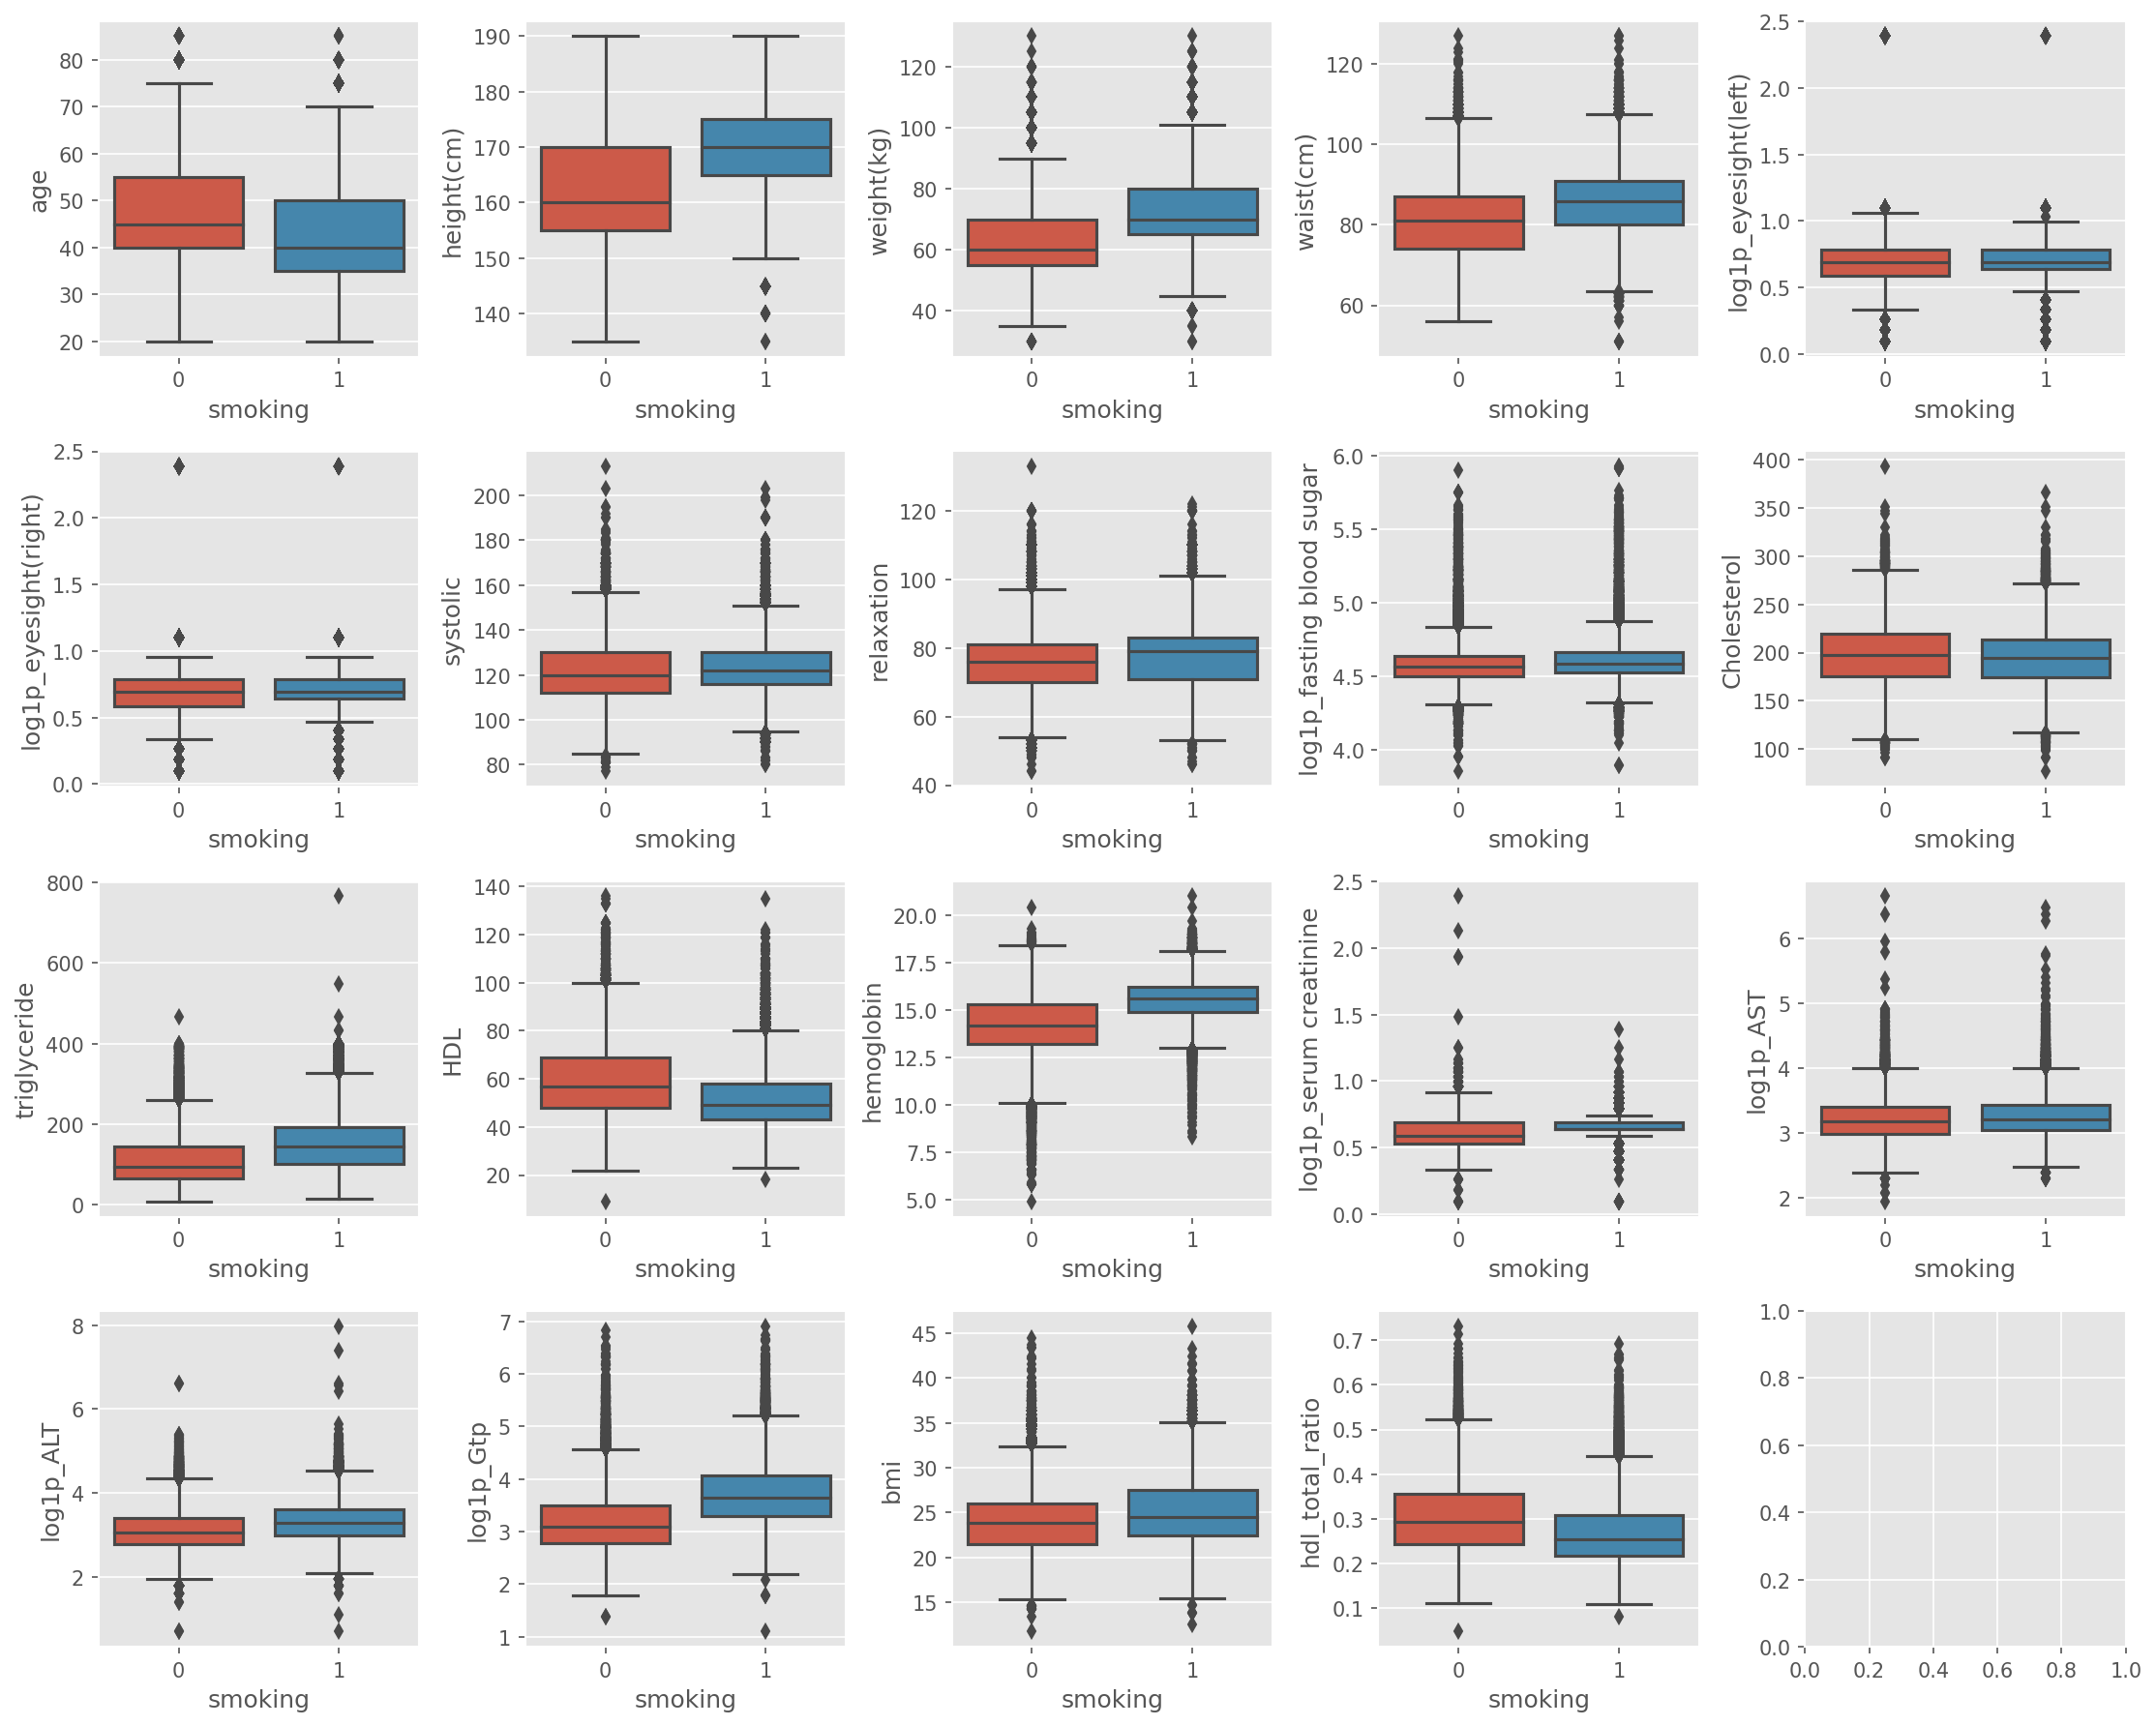

In [24]:
numerical_features = train.drop(['smoking', 'dental caries'], axis=1).columns.tolist()
n_rows = 4
n_cols = 5
fig,axs = plt.subplots(n_rows, n_cols,figsize=(3 * n_cols, 3 * n_rows))
for i in range(n_rows):
    for j in range(n_cols):
        col_index = n_cols*i+j
        if col_index == len(numerical_features):
            break
            
        _ = sns.boxplot(data=train, y=numerical_features[col_index], x='smoking', ax=axs[i,j])
        
fig.tight_layout()

### Preparing the data

In [25]:
input_preproc = ColumnTransformer(
    [('robust_scaler', QuantileTransformer(output_distribution='normal'), train.drop(['smoking', 'dental caries'], axis=1).columns)],
    remainder='passthrough'
)

X = input_preproc.fit_transform(train.drop('smoking', axis=1))
y = train['smoking'].values

## Feed forward neural network.

The architecture consists of one or more hidden layers followed by the final output layer. To directly model linear effects, we introduce residual connections from the inputs to the outputs. Each hidden layer in the network consists of a dense layer followed by ~batch normalization, ReLU activation~ selu activation ([paper](https://proceedings.neurips.cc/paper_files/paper/2017/hash/5d44ee6f2c3f71b73125876103c8f6c4-Abstract.html)) and (alpha-)dropout.

**TODO**: Set activation type as an hyperparameter. 

In [26]:
class NeuralNetClassifier(pl.LightningModule):
    def __init__(self, input_dim:int, params:Dict={}, verbose=False):
        super(NeuralNetClassifier, self).__init__()
        self.params = params
        self.input_dim = input_dim
        self.verbose = []
        
        self.auroc = torchmetrics.AUROC(task='binary')
        
        n_hidden = params.get('n_hidden', 2)
        hsize_list = [params.get(f'hsize{i}', 64) for i in range(1, n_hidden + 1)]
        dropouts_list = [params.get(f'dropout{i}', 0.05) for i in range(1, n_hidden + 1)]
        
        self.ff = nn.Sequential()
        
        for i in range(n_hidden):
            self.ff.append(nn.Linear(input_dim if i == 0 else hsize_list[i - 1], hsize_list[i]))
            # initialization neeed
            self.ff[-1].apply(self.init_selu)
            self.ff.append(nn.SELU())
            self.ff.append(nn.AlphaDropout(dropouts_list[i]))
#             self.ff.append(nn.BatchNorm1d(hsize_list[i]))
#             self.ff.append(nn.ReLU())
#             self.ff.append(nn.Dropout(dropouts_list[i]))
            
        
        # output layer
        self.output = nn.Sequential(
            nn.Linear(input_dim + hsize_list[-1], 1),
            nn.Sigmoid()
        )
        
    def init_selu(self, layer):
        if isinstance(layer, nn.Linear):
            torch.nn.init.kaiming_normal_(layer.weight, nonlinearity='selu')
            torch.nn.init.constant_(layer.bias, 0)
        
    def forward(self, x):
        ff_out = self.ff(x)
        
        # concate inputs with output of the hidden layers
        ff_out = torch.cat([x, ff_out], dim=-1)
        
        return self.output(ff_out).flatten()
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = nn.BCELoss()(y_pred, y)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        
        # compute validation loss
        loss = nn.BCELoss()(y_pred, y)
        self.log("val_loss", loss, on_epoch=True, prog_bar=True)
        
        # update ROC AUC
        self.auroc.update(y_pred, y)
        self.log('val_auc', self.auroc, on_step=False, on_epoch=True, prog_bar=True)
        
        return loss
    
    def configure_optimizers(self):
        optimizer = optim.Adam(
            self.parameters(), lr=self.params.get('learning_rate', 1e-3)
        )
        
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='max', factor=0.1, patience=5,
            threshold = 1e-4, threshold_mode='abs'
        )
        return {
            "optimizer": optimizer, "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_auc"
            }
        }

The `build_and_fit` function below is the main training function.

1. We split the dataset into training and validation sets using a 90-10 split with stratification on the labels
2. I monitor the validation AUC at the end of each epoch:
    1. We have a callback to reduce learning rate if there is no improvement in the validation AUC after 5 epochs. This is implemented in the `NeuralNetClassifier` itself. 
    2. We have an early stopping callback to terminate training and restore the best model if there is no improvement in the validation AUC after 10 epochs.

In [27]:
def build_and_fit(X, y, params:Dict={}, verbose:bool=False, resample_seed:int=None):
    # Further divide into train and validation splits for early stopping
    # stratified on the labels
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.1, random_state=resample_seed, stratify= y
    )

    train_dataset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
    val_dataset = TensorDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float())
    
    batch_size = params.get('batch_size', 1024)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=1024)

    model = NeuralNetClassifier(X.shape[1], params,verbose=verbose)

    trainer = pl.Trainer(
        max_epochs=100,
        callbacks=[
            # early stopping
            pl.callbacks.EarlyStopping(monitor='val_auc', mode='max', patience=15, verbose=verbose, min_delta=1e-4),
            # checkpoint,
            pl.callbacks.ModelCheckpoint(save_top_k=1, monitor="val_auc", mode="max",verbose=verbose),
            #pl.callbacks.LearningRateMonitor(logging_interval='epoch'),
            pl.callbacks.TQDMProgressBar(refresh_rate=0 if not verbose else 10),
        ],
        accelerator="gpu",
        enable_checkpointing=True,
        logger=False
    )

    trainer.fit(model, train_loader, val_loader)

    return model

Finally, the `generate_predictions` function returns predictions from the model on the test set.

In [28]:
def generate_predictions(model:torch.nn.Module,X_test:np.ndarray) -> np.ndarray:
    # generate predictions on X_test from model
    
    # set model to evaluation mode (to be safe)
    _ = model.eval()
    
    test_loader = DataLoader(torch.from_numpy(X_test).float(),batch_size=2000)
    predictions = []
    
    with torch.no_grad():
        for x in test_loader:
            y_pred = model(x)
            predictions.append(y_pred.cpu().numpy())
            
    return np.concatenate(predictions)

## Tuning hyperparameters with Optuna and 4-fold CV

Neural network models are usually sensitive to the choice of their hyperparameters. We will tune the following hyperparameters of the network using Optuna:

1. learning rate for the Adam optimizer
3. the number of hidden layers
4. the number of units in each hidden layer
5. the dropout rate in each hidden layer 

**Note**: the number of hyperparameters is variable - depends on the number of hidden layers. Optuna allows variable number of hyperparameters with the default `TPESampler`, which is used to generate new trials (i.e., hyperparameter configurations).


In [29]:
import warnings
def fit_and_test_fold(config:Dict,train_index,test_index) -> float:
    X_train = X[train_index,:];X_test = X[test_index,:]
    y_train = y[train_index,...]; y_test = y[test_index,...]
    
    # fit model on training data
    with warnings.catch_warnings():
        # PossibleUserWarnings 
        warnings.simplefilter(action='ignore')
        model = build_and_fit(X_train,y_train, config)
    
    # generate prediction probabilities on test dataset
    test_prob = generate_predictions(model,X_test)
    
    # return mean_absolute_error
    return roc_auc_score(y_test,test_prob)

# loss function
def objective(trial):
    config = {
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1,log=True),
        #'batch_size':trial.suggest_int('batch_size',64, 1024),
        'n_hidden':trial.suggest_int('n_hidden', 2, 4),
    }
    
    for i in range(1,config['n_hidden']+1):
        # layer sizes for the common branch
        config['hsize%d'%i] = trial.suggest_int('hsize%d'%i, 8, 512, log=True) 
        config['dropout%d'%i] = trial.suggest_float('dropout%d'%i, 0, 0.2)
    
    
    
    cv = StratifiedKFold(n_splits=4,shuffle=True,random_state=1)
    cv_losses = [None]*4
    for i,(train_index,test_index) in enumerate(cv.split(X, y)):
        cv_losses[i] = fit_and_test_fold(config,train_index,test_index)
    
    return np.mean(cv_losses)

# the first `n_startup_trials` trials are drawn through random sampling
sampler = optuna.samplers.TPESampler(
    n_startup_trials=10,seed=1
)

study = optuna.create_study(
    directions=['maximize'],sampler=sampler,study_name='mlp'
)

try:
    # maximum of 100 trials and a maximum wall-clock time of 7200 secs (2 hrs)
    study.optimize(objective, n_trials=100, timeout=7200) 
except Exception as e:
    print(e)

[I 2023-10-28 22:46:36,868] A new study created in memory with name: mlp
[I 2023-10-28 22:50:31,513] Trial 0 finished with value: 0.8569212160397617 and parameters: {'learning_rate': 0.006824078427098834, 'n_hidden': 4, 'hsize1': 8, 'dropout1': 0.060466514526367955, 'hsize2': 14, 'dropout2': 0.018467718953759562, 'hsize3': 16, 'dropout3': 0.06911214540860955, 'hsize4': 40, 'dropout4': 0.1077633468006714}. Best is trial 0 with value: 0.8569212160397617.
[I 2023-10-28 22:54:57,810] Trial 1 finished with value: 0.8549864631747284 and parameters: {'learning_rate': 0.006892694481137703, 'n_hidden': 4, 'hsize1': 18, 'dropout1': 0.1756234872781891, 'hsize2': 8, 'dropout2': 0.13409350203568046, 'hsize3': 44, 'dropout3': 0.11173796568915034, 'hsize4': 14, 'dropout4': 0.039620297816975764}. Best is trial 0 with value: 0.8569212160397617.
[I 2023-10-28 22:57:21,173] Trial 2 finished with value: 0.8450674681110841 and parameters: {'learning_rate': 0.03994745694560917, 'n_hidden': 4, 'hsize1': 28, 

In [30]:
results = study.trials_dataframe(attrs=('number','value', 'duration', 'params'))
results = results.rename(columns={'value':'roc-auc'})
results['duration'] = results['duration']/np.timedelta64(1, 's')
results = results.sort_values(by='roc-auc',ascending=False)
results.to_csv('cv_auc_history.csv',index=False)
# print the top 10 results
results.head(10)

,number,roc-auc,duration,params_dropout1,params_dropout2,params_dropout3,params_dropout4,params_hsize1,params_hsize2,params_hsize3,params_hsize4,params_learning_rate,params_n_hidden
31,31,0.860234,221.232411,0.039240,0.001678,NaN,NaN,300,33,NaN,NaN,0.003031,2
27,27,0.860131,199.214147,0.000092,0.118535,NaN,NaN,246,65,NaN,NaN,0.004540,2
32,32,0.860027,265.184356,0.060195,0.027854,NaN,NaN,345,27,NaN,NaN,0.003278,2
30,30,0.859988,252.614209,0.039551,0.003217,NaN,NaN,283,30,NaN,NaN,0.002977,2
12,12,0.859951,252.042850,0.039493,0.084552,NaN,NaN,98,100,NaN,NaN,0.014569,2
29,29,0.859884,197.489444,0.002873,0.003554,NaN,NaN,268,61,NaN,NaN,0.005724,2
26,26,0.859859,260.305042,0.000932,0.119058,NaN,NaN,91,73,NaN,NaN,0.005022,2
28,28,0.859697,227.987371,0.005904,0.088935,0.035925,NaN,256,43,26.0,NaN,0.004782,3
14,14,0.859630,217.529132,0.009473,0.120046,NaN,NaN,47,90,NaN,NaN,0.014313,2
6,6,0.859590,222.611407,0.029346,0.139952,NaN,NaN,85,90,NaN,NaN,0.009619,2


## Final model - Ensembling

Rather than training a single model, we will train an ensemble of models, where each model is trained using a different training-validation split (and possibly different initial guessess for the parameters of the network).

In [31]:
n_ensemble = 10
models = [None]*n_ensemble

for i in range(n_ensemble):
    print(f'********* Model {i+1} *********')
    with warnings.catch_warnings():
        # PossibleUserWarnings 
        warnings.simplefilter(action='ignore')
        models[i] = build_and_fit(X, y, study.best_params, verbose=False, resample_seed=i)
    
    # save model weights to disk
    torch.save(models[i].state_dict(),f'model_{i}.pt')
    
    print()

********* Model 1 *********

********* Model 2 *********

********* Model 3 *********

********* Model 4 *********

********* Model 5 *********

********* Model 6 *********

********* Model 7 *********

********* Model 8 *********

********* Model 9 *********

********* Model 10 *********



## Submission

In [32]:
# removing checkpoints
!rm -r /kaggle/working/checkpoints/

In [33]:
# preprocess test data

# drop features
test = test.drop(high_mode_per.index.tolist(), axis=1)
del test['LDL']

# new features
new_features(test)

# Log-transform 
test[cols_w_positive_skew] = test[cols_w_positive_skew].apply(np.log1p)
test = test.rename({col:f'log1p_{col}' for col in cols_w_positive_skew}, axis=1)

In [34]:
X_test = input_preproc.transform(test)
preds = []
for model in models:
    preds.append(generate_predictions(model,X_test))
    

y_test_prob = np.mean(preds,axis=0)

submission = pd.DataFrame({
    'id':test.index.values,
    'defects': y_test_prob
})
submission.to_csv('submission.csv',index=False)